In [225]:
import json
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

In [20]:
from ace_extraction import load_dataset_and_tagger
from infonet.evaluation import mention_relation_stats, mention_boundary_stats

In [13]:
model_f = 'extractor_100_0.25_100_180'
line = open('experiments/'+model_f+'_eval_stats.json', 'r').readlines()[-1]
eval_stats = json.loads(line)

In [16]:
dev_stats = eval_stats['dev_stats']

In [17]:
print sorted(dev_stats.keys())

[u'--NULL--', u'NULL', u'b_preds', u'b_trues', u'coreference', u'coreference:--SameAs--', u'edge', u'entity', u'entity:FAC', u'entity:GPE', u'entity:LOC', u'entity:ORG', u'entity:PER', u'entity:VEH', u'entity:WEA', u'event-anchor', u'event-anchor:Business:Declare-Bankruptcy', u'event-anchor:Business:End-Org', u'event-anchor:Business:Merge-Org', u'event-anchor:Business:Start-Org', u'event-anchor:Conflict:Attack', u'event-anchor:Conflict:Demonstrate', u'event-anchor:Contact:Meet', u'event-anchor:Contact:Phone-Write', u'event-anchor:Justice:Appeal', u'event-anchor:Justice:Arrest-Jail', u'event-anchor:Justice:Charge-Indict', u'event-anchor:Justice:Convict', u'event-anchor:Justice:Execute', u'event-anchor:Justice:Fine', u'event-anchor:Justice:Pardon', u'event-anchor:Justice:Release-Parole', u'event-anchor:Justice:Sentence', u'event-anchor:Justice:Sue', u'event-anchor:Justice:Trial-Hearing', u'event-anchor:Life:Be-Born', u'event-anchor:Life:Die', u'event-anchor:Life:Injure', u'event-anchor:L

In [18]:
print len(dev_stats['m_trues'])

80


### How to view errors?

* Given list of docs, aggregate over them
* Show confusion matrix
* For entities, event anchors, relations, and event args do:
* Enumerate over mention types, the relation types
    * Sort mentions by nodetype, mtype
    * Sort relations by reltype, rsubtype name, direction
* Report the class-specific f1 stats and its rank within group
* Show false negatives and their concordance
* Then take all false positives that don't overlap the false negatives and display these
* Report the mention width, and widths and distances for relations
* Report the NULL percentage
* Report the percentage of errors due to boundary predictions vs misclassifications
    * NOTE: This is typically atleast > 50% boundary errors for mentions.  Need to get this higher.


### Types of errors:

#### Mentions:
* Should have been a mention, but we didn't predict the boundary correctly (it overlaps or is non-existent)
* We predicted a boundary that is totally spurious - it doesn't overlap a true boundary at all
* We got the boundary correct, but mispredicted the class

#### Relations:
* Should have been a relation, but we didn't predict one or both of the mention boundaries correctly
* Should have been a relatio

In [189]:
entity_keys = sorted([k for k in dev_stats.keys() if k.startswith('entity')])
eventanchor_keys = sorted([k for k in dev_stats.keys() if k.startswith('event-anchor')])
def edge_sortkey(edgename):
    edgename = ':'.join(edgename.split(':')[1:])
    direction, edgename = edgename[:2], edgename[2:]
    return edgename, direction
relation_keys = sorted([k for k in dev_stats.keys() if 'relation' in k], key=edge_sortkey)
eventarg_keys = sorted([k for k in dev_stats.keys() if 'event-argument' in k], key=edge_sortkey)

In [304]:
def error_analysis(stats, start=0, end=None, context=7):
    if end is None:
        end = len(stats)

    # for confusion matrices
    node_map = {}
    for i,k in enumerate(entity_keys+eventanchor_keys):
        node_map[k] = i
    edge_map = {}
    for i,k in enumerate(relation_keys+eventarg_keys+['--NULL--', 'coreference:--SameAs--']):
        edge_map[k] = i
    # confusion matrix
    # we consider classification confusion, only when the boundaries are correct
    node_cm = np.zeros((len(node_map.keys()), len(node_map.keys())))


    # get all of the examples of errors
    examples = {k:{'fns':[], 'fps':[], 'tps':[], 'miss':[], 'fn':0, 'fp':0, 'tp':0}
                for k in node_map.keys()+edge_map.keys()}
    zipped = zip(stats['xs'][start:end], 
                 stats['b_trues'][start:end], 
                 stats['b_preds'][start:end], 
                 stats['m_trues'][start:end], 
                 stats['m_preds'][start:end])
    for doc_i, (xs, btrues, bpreds, mtrues, mpreds) in enumerate(zipped):
    #     print "*** Document {} ****************************************".format(start+doc_i)
        truespans = {tuple(m[:2]) for m in mtrues}
        predspans = {tuple(m[:2]) for m in mpreds}
        true2type = {tuple(m[:2]):m[2] for m in mtrues}
        pred2type = {tuple(m[:2]):m[2] for m in mpreds}
    #     mtrues, mpreds = {tuple(m) for m in mtrues}, {tuple(m) for m in mpreds}
        fnspans = truespans - predspans
        fpspans = predspans - truespans
        tpspans = truespans & predspans
        assert (fnspans | fpspans | tpspans) == (truespans | predspans) 
        # all predicted spans that overlap with each true span
        overlaps = {s:[p for p in predspans 
                       if (p[0] >= s[0] and p[0] < s[1]) 
                       or (p[1] > s[0] and p[1] <= s[1])]
                    for s in truespans}

        # all mentions that should have been predicted, but were missed
        seenfps = set({})
        for m in fnspans:
            fps = overlaps[m]
            # remove overlapping fps from fpspans, so that looking at fps gives spurious only
            fpspans -= set(fps)
            span = (m[0]-context, m[1]+context+1)

            x = xs[span[0]:span[1]]
            indices = range(span[0], span[1])
            idxs = ["{: ^{}}".format(str(b)[-len(t):], len(t)) for b,t in zip(indices, x)]
            bt = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(btrues[span[0]:span[1]], x)]
            bp = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(bpreds[span[0]:span[1]], x)]
            mlen = len(" ".join(x[context:context+m[1]-m[0]]))
            mt = [" ".join(['-'*len(t) for t in x[:context]]), 
                  "{:~^{}}".format(true2type[m][-mlen:], mlen), 
                  " ".join(['-'*len(t) for t in x[context+m[1]-m[0]:]])
                  ]
            mp = ['-'*len(t) for t in x]

            # add context delimiters
            x.insert(context, '[')
            x.insert(context+m[1]-m[0]+1, ']')
            indices.insert(context, '[')
            indices.insert(context+m[1]-m[0]+1, ']')
            idxs.insert(context, '[')
            idxs.insert(context+m[1]-m[0]+1, ']')
            bt.insert(context, '[')
            bt.insert(context+m[1]-m[0]+1, ']')
            bp.insert(context, '[')
            bp.insert(context+m[1]-m[0]+1, ']')
            mt.insert(1, '[')
            mt.insert(3, ']')
            mp.insert(context, '[')
            mp.insert(context+m[1]-m[0]+1, ']')

            # format false positives for this mention
            offset = 0
            max_i = max([i for i in indices if type(i) is int])
            min_i = min([i for i in indices if type(i) is int])
            for j, fp in enumerate(sorted(fps, key=lambda x:x[0])):
                fp0, fp1 = fp
                if fp1 > max_i: fp1 = max_i
                if fp0 < min_i: fp0 = min_i
                s, e = indices.index(fp0), indices.index(fp1)
                s -= offset
                e -= offset
                t = pred2type[fp]
                if j == len(fps)-1:
    #                 print fp, m
                    if fp1 > m[1]: # handle the trailing ']' for fps that overflow true boundary
                        pass
                    elif e-1 == s:
                        pass
                    else:
                        e -= 1
                t_wid = len(" ".join(mp[s:e]))
                mp[s:e] = ['{:~^{}}'.format(t[-t_wid:], t_wid)]
                offset += e-s-1
                if fp not in seenfps:
                    examples[pred2type[fp]]['fp'] += 1
                seenfps |= {fp}

            # add to examples:
            example = {
                'indices':idxs,
                'tokens':x,
                'b trues':bt,
                'b preds':bp,
                'm true': mt,
                'm preds':mp,
                'm true len':m[1]-m[0],
                'm pred types':[pred2type[t] for t in fps]
            }
            examples[true2type[m]]['fns'].append(example)
            examples[true2type[m]]['fn'] += 1
    #         print
    #         print "indices: ... {} ...".format(" ".join(idxs))
    #         print "tokens:  ... {} ...".format(" ".join(x))
    #         print "b trues: ... {} ...".format(" ".join(bt))
    #         print "b preds: ... {} ...".format(" ".join(bp))
    #         print "m true : ... {} ...".format(" ".join(mt))
    #         print "m preds: ... {} ...".format(" ".join(mp))

        # all mentions that were totally spurious
        for m in fpspans:
            m = (int(m[0]), int(m[1]))
            span = (m[0]-context, m[1]+context+1)
    #         print 

            x = xs[span[0]:span[1]]
            indices = range(span[0], span[1])
            idxs = ["{: ^{}}".format(str(b)[-len(t):], len(t)) for b,t in zip(indices, x)]
            bt = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(btrues[span[0]:span[1]], x)]
            bp = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(bpreds[span[0]:span[1]], x)]
            mlen = len(" ".join(x[context:context+m[1]-m[0]]))
    #         mt = [" ".join(['-'*len(t) for t in x[:context]]), 
    #               "{:~^{}}".format(true2type[m][-mlen:], mlen), 
    #               " ".join(['-'*len(t) for t in x[context+m[1]-m[0]:]])
    #               ]
    #         mp = ['-'*len(t) for t in x]

            # add context delimiters
            x.insert(context, '[')
            x.insert(context+m[1]-m[0]+1, ']')
            indices.insert(context, '[')
            indices.insert(context+m[1]-m[0]+1, ']')
            idxs.insert(context, '[')
            idxs.insert(context+m[1]-m[0]+1, ']')
            bt.insert(context, '[')
            bt.insert(context+m[1]-m[0]+1, ']')
            bp.insert(context, '[')
            bp.insert(context+m[1]-m[0]+1, ']')
    #         mt.insert(1, '[')
    #         mt.insert(3, ']')
    #         mp.insert(context, '[')
    #         mp.insert(context+m[1]-m[0]+1, ']')

            # add to examples:
            example = {
                'indices':idxs,
                'tokens':x,
                'b trues':bt,
                'b preds':bp,
            }
            examples[pred2type[m]]['fps'].append(example)
            examples[pred2type[m]]['fp'] += 1
        # all mentions with the correct spans
        for m in tpspans:
            m = (int(m[0]), int(m[1]))
            span = (m[0]-context, m[1]+context+1)

            x = xs[span[0]:span[1]]
            indices = range(span[0], span[1])
            idxs = ["{: ^{}}".format(str(b)[-len(t):], len(t)) for b,t in zip(indices, x)]
            bt = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(btrues[span[0]:span[1]], x)]
            bp = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(bpreds[span[0]:span[1]], x)]
            mlen = len(" ".join(x[context:context+m[1]-m[0]]))+4
            mt = [" ".join(['-'*len(t) for t in x[:context]]), 
                  "{:~^{}}".format(true2type[m][-mlen:], mlen), 
                  " ".join(['-'*len(t) for t in x[context+m[1]-m[0]:]])
                  ]
            mp = [" ".join(['-'*len(t) for t in x[:context]]), 
                  "{:~^{}}".format(pred2type[m][-mlen:], mlen), 
                  " ".join(['-'*len(t) for t in x[context+m[1]-m[0]:]])
                  ]

            # add context delimiters
            x.insert(context, '[')
            x.insert(context+m[1]-m[0]+1, ']')
            indices.insert(context, '[')
            indices.insert(context+m[1]-m[0]+1, ']')
            idxs.insert(context, '[')
            idxs.insert(context+m[1]-m[0]+1, ']')
            bt.insert(context, '[')
            bt.insert(context+m[1]-m[0]+1, ']')
            bp.insert(context, '[')
            bp.insert(context+m[1]-m[0]+1, ']')
            mt.insert(context, '[')
            mt.insert(context+m[1]-m[0]+1, ']')
            mp.insert(context, '[')
            mp.insert(context+m[1]-m[0]+1, ']')

    #         print
    #         print "True:{}, Pred:{}".format(true2type[m], pred2type[m])
    #         print "indices: ... {} ...".format(" ".join(idxs))
    #         print "tokens:  ... {} ...".format(" ".join(x))
    #         print "b trues: ... {} ...".format(" ".join(bt))
    #         print "b preds: ... {} ...".format(" ".join(bp))
    #         print "m true : ... {} ...".format(" ".join(mt))
    #         print "m preds: ... {} ...".format(" ".join(mp))

            # add to examples:
            example = {
                'indices':idxs,
                'tokens':x,
                'b trues':bt,
                'b preds':bp,
                'm true': mt,
                'm preds':mp,
                'm true len':m[1]-m[0],
                'm pred type':pred2type[m]
            }
            node_cm[node_map[true2type[m]], node_map[pred2type[m]]] += 1
            if true2type[m] == pred2type[m]:
                examples[true2type[m]]['tps'].append(example)
                examples[true2type[m]]['tp'] += 1
#                 examples[pred2type[m]]['tp'] += 1
            else:
                examples[true2type[m]]['miss'].append(example)
                examples[true2type[m]]['fn'] += 1
                examples[pred2type[m]]['fp'] += 1

    # get class specific f1s
    for k in node_map.keys():
        examples[k]['support'] = examples[k]['tp'] + examples[k]['fp'] + examples[k]['fn']
        examples[k]['precision'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fp'] + 1e-15)
        examples[k]['recall'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fn'] + 1e-15)
        examples[k]['f1'] = (2*examples[k]['precision']*examples[k]['recall']
                             /(examples[k]['precision']+examples[k]['recall']+1e-15))

    # nodetype f1s
    for k in entity_keys:
        examples['entity']['tp'] += examples[k]['tp']
        examples['entity']['fp'] += examples[k]['fp']
        examples['entity']['fn'] += examples[k]['fn']
        examples['entity']['fns'].extend(examples[k]['fns'])
        examples['entity']['fps'].extend(examples[k]['fps'])
        examples['entity']['miss'].extend(examples[k]['miss'])
    k = 'entity'
    examples[k]['support'] = examples[k]['tp'] + examples[k]['fp'] + examples[k]['fn']
    examples[k]['precision'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fp'] + 1e-15)
    examples[k]['recall'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fn'] + 1e-15)
    examples[k]['f1'] = (2*examples[k]['precision']*examples[k]['recall']
                             /(examples[k]['precision']+examples[k]['recall']+1e-15))

    for k in eventanchor_keys:
        examples['event-anchor']['tp'] += examples[k]['tp']
        examples['event-anchor']['fp'] += examples[k]['fp']
        examples['event-anchor']['fn'] += examples[k]['fn']
        examples['event-anchor']['fns'].extend(examples[k]['fns'])
        examples['event-anchor']['fps'].extend(examples[k]['fps'])
        examples['event-anchor']['miss'].extend(examples[k]['miss'])
    k = 'event-anchor'
    examples[k]['support'] = examples[k]['tp'] + examples[k]['fp'] + examples[k]['fn']
    examples[k]['precision'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fp'] + 1e-15)
    examples[k]['recall'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fn'] + 1e-15)
    examples[k]['f1'] = (2*examples[k]['precision']*examples[k]['recall']
                             /(examples[k]['precision']+examples[k]['recall']+1e-15))
    
    examples['node_cm'] = node_cm
    examples['node_map'] = node_map
    return examples
#         print 
#         print "indices: ... {} ...".format(" ".join(idxs))
#         print "tokens:  ... {} ...".format(" ".join(x))
#         print "b trues: ... {} ...".format(" ".join(bt))
#         print "b preds: ... {} ...".format(" ".join(bp))

# Todo next:

* also calculate type-specific f1s by true mention
* convert above cell to a function that returns the examples given limits and context size
* create function that outputs errors in meaningful order
* create function that creates confusion matrices
* categorize error proportions by boundary fn, fp, and misclassification percentages

* do the same for relations



In [305]:
examples = error_analysis(dev_stats, context=15)

/Users/thomaseffland/.virtualenvs/infonet/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


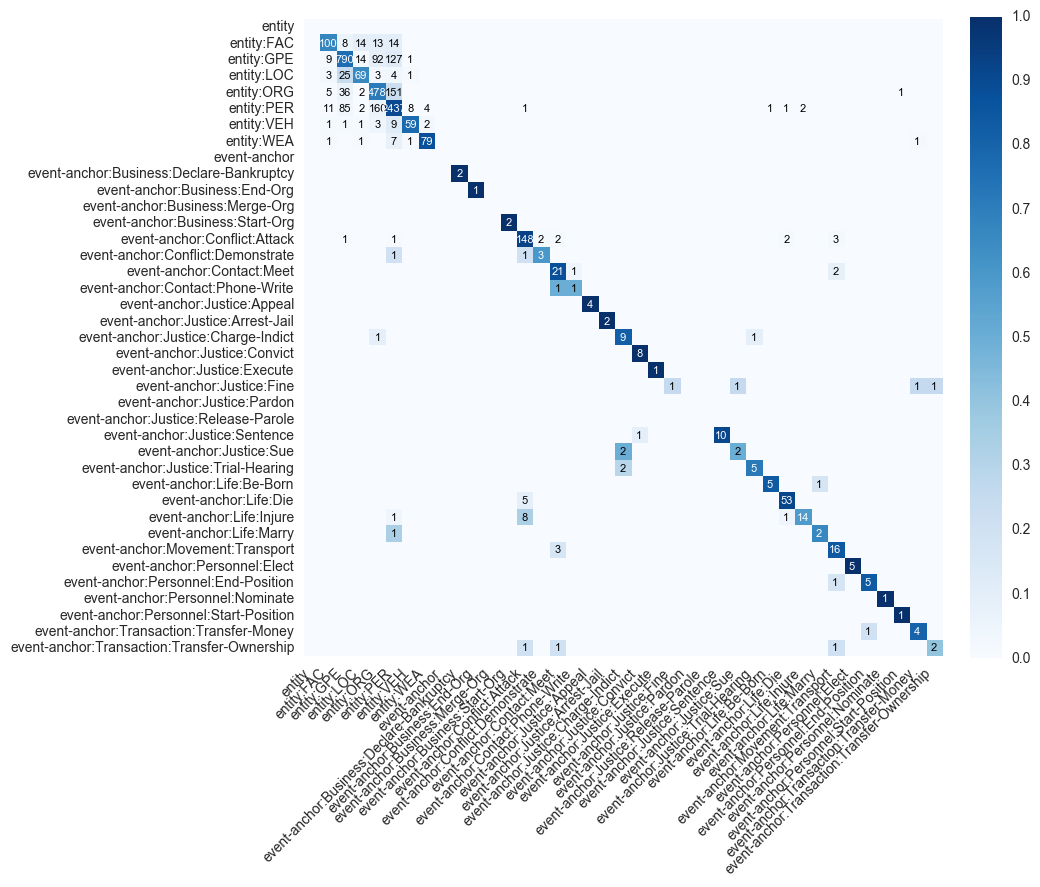

In [306]:
def plot_cm(cm, cm_map, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1, figsize=(9,9))
#     im = ax.imshow(cm, interpolation='nearest', aspect='auto', cmap='jet')
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    
    # print nonzero raw counts
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        norm = cm_normalized[x_val, y_val]
        c = "%i" % (cm.astype('int')[x_val, y_val])
        if norm > 0.0:
            color = 'white' if norm > .5 else 'black'
            ax.text(y_val, x_val, c, va='center', ha='center', color=color, size=8)
    
    # actual plot
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
#     divider = plt.make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    a = [t-.5 for t in range(len(cm_map))]
    a = range(len(cm_map))
    ax.set_xticks(a)
    ax.set_xticklabels([k for k,i in sorted(cm_map.items(), key=lambda x:x[1])], 
                        rotation=45, horizontalalignment='right', x=10)
    ax.set_yticks(a)
    ax.set_yticklabels([k for k,i in sorted(cm_map.items(), key=lambda x:x[1])], y=-100)
    ax.grid(False)
plot_cm(examples['node_cm'], examples['node_map'])

In [330]:
def print_examples(examples):
    print '\nEntities', '-*'*40
    for k in entity_keys:
        print '*'*80
        d = examples[k]
        boundaries = d['fns'] + d['fps']
        miss = d['miss']
        total = float(len(boundaries) + len(miss))
        b_per, m_per = len(boundaries)/total, len(miss)/total
        print '{0}: P:{1:2.4f}, R:{2:2.4f}, F1:{3:2.4f}'.format(
            k, d['precision'], d['recall'], d['f1'])
        print '\t support:{}, tp:{}, fp:{}, fn:{}'.format(
            d['support'], d['tp'], d['fp'], d['fn'])
        print '\t boundary: {0:2.2f}%, class: {1:2.2f}%'.format(
            b_per*100, m_per*100)
        if k == 'entity': continue
        print '\n*** False Negatives ({}/{} total) ***'.format(len(d['fns']), int(total))
        for j, example in enumerate(d['fns']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print "m true : ... {} ...".format(" ".join(example['m true']))
            print "m preds: ... {} ...".format(" ".join(example['m preds']))
            print "mtrue wid:{} , mpred types:{}".format(example['m true len'], example['m pred types'])
            print
        
        print '\n*** False Positives ({}/{} total) ***'.format(len(d['fps']), int(total))
        for j, example in enumerate(d['fps']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print
            
        print '\n*** Misclassifications ({}/{} total) ***'.format(len(d['miss']), int(total))
        for j, example in enumerate(d['miss']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print "m true : ... {} ...".format(" ".join(example['m true']))
            print "m preds: ... {} ...".format(" ".join(example['m preds']))
            print "mtrue wid:{} , mpred type: {}".format(example['m true len'], example['m pred type'])
            print
            
    print 'Event Anchors', '-*'*40
    for k in eventanchor_keys:
        print '*'*80
        d = examples[k]
        boundaries = d['fns'] + d['fps']
        miss = d['miss']
        total = float(len(boundaries) + len(miss))
        b_per, m_per = len(boundaries)/total, len(miss)/total
        print '{0}: P:{1:2.4f}, R:{2:2.4f}, F1:{3:2.4f}'.format(
            k, d['precision'], d['recall'], d['f1'])
        print '\t support:{}, tp:{}, fp:{}, fn:{}'.format(
            d['support'], d['tp'], d['fp'], d['fn'])
        print '\t boundary: {0:2.2f}%, class: {1:2.2f}%'.format(
            b_per*100, m_per*100)
        if k == 'event-anchor': continue
        print '\n*** False Negatives ({}/{} total) ***'.format(len(d['fns']), int(total))
        for j, example in enumerate(d['fns']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print "m true : ... {} ...".format(" ".join(example['m true']))
            print "m preds: ... {} ...".format(" ".join(example['m preds']))
            print "mtrue wid:{} , mpred types:{}".format(example['m true len'], example['m pred types'])
            print
        
        print '\n*** False Positives ({}/{} total) ***'.format(len(d['fps']), int(total))
        for j, example in enumerate(d['fps']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print
            
        print '\n*** Misclassifications ({}/{} total) ***'.format(len(d['miss']), int(total))
        for j, example in enumerate(d['miss']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print "m true : ... {} ...".format(" ".join(example['m true']))
            print "m preds: ... {} ...".format(" ".join(example['m preds']))
            print "mtrue wid:{} , mpred type: {}".format(example['m true len'], example['m pred type'])
            print

In [331]:
print entity_keys

[u'entity', u'entity:FAC', u'entity:GPE', u'entity:LOC', u'entity:ORG', u'entity:PER', u'entity:VEH', u'entity:WEA']


In [332]:
del cap

In [333]:
%%capture cap
print_examples(examples)

In [334]:
with open('mention_errors.txt', 'w') as f:
    f.write(cap.stdout)

In [335]:
!tail mention_errors.txt


Example: 2
indices: ... 164  5 166  167  168   169  170  171  172  173   174  75 176  7   178   [   179    ]  180  181  2 3  184  5 6  187  8 9  190  1 2 193  4 ...
tokens:  ... know , the first time since the <UNK> deal that there 's been a hostile [ takeover ] using debt . < /POST > < /TEXT > < /BODY > < /DOC > ...
b trues: ...  O   O  O    O    O     O    O  B-ent  O    O     O   O   O   O    O    [ B-event- ]   O    O   O O   O   O O   O   O O   O   O O  O   O ...
b preds: ...  O   O  O    O    O     O    O    O    O    O   B-ent O   O   O    O    [ B-event- ]   O    O   O O   O   O O   O   O O   O   O O  O   O ...
m true : ... ---- - --- ----- ---- ----- --- ----- ---- ---- ----- -- ---- - ------- er-Ownership ----- ---- - - ----- - - ----- - - ----- - - ---- - [ ] ...
m preds: ... ---- - --- ----- ---- ----- --- ----- ---- ---- ----- -- ---- - ------- Contact:Meet ----- ---- - - ----- - - ----- - - ----- - - ---- - [ ] ...
mtrue wid:1 , mpred type: event-anchor:Contact:Meet



In [323]:
print Out.keys()

[164, 165, 166, 138, 175, 51, 23, 132]


In [324]:
%%capture cap
print 'stuff'
print cap.stdout

In [325]:
print cap.stdout

stuff

Entities -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
********************************************************************************
entity: P:0.6891, R:0.6594, F1:0.6739
	 support:7894, tp:4012, fp:1810, fn:2072
	 boundary: 68.29%, class: 31.71%
********************************************************************************
entity:FAC: P:0.6024, R:0.4132, F1:0.4902
	 support:308, tp:100, fp:66, fn:142
	 boundary: 71.84%, class: 28.16%

*** False Negatives (93/174 total) ***
Example: 0
indices: ... 1   782   3  784   5   786    7 788    789    0  791   792  793 794  795  [ 796  ] 7 8  799  0 1 802  3 4   805   6  807   808     809    0    811    2 ...
tokens:  ... < SPEAKER > BEGALA < /SPEAKER > Dr. Palmisano , first thank you for being [ here ] . < /TURN > < TURN > < SPEAKER > <UNK> <UNK> PALMISANO , PRESIDENT - ...
b trues: ... O    O    O B-enti O    O     O B-e B-entity  O   O     O   B-e  O    O   [ B-en ] O O   O   O O  O   O O    O  